In [1]:
%matplotlib inline

In [190]:
import json
import matplotlib.pyplot as plt
import numpy as np
import nltk
nltk.data.path.append("/Users/Michel_home/Documents/Projects/PythonPlay/nltk_data")
from nltk.stem.snowball import SnowballStemmer
#import nltk.corpus
from nltk.corpus import stopwords

import pandas as pd
import pickle as pkl
import pymysql as mdb
import random
import seaborn as sns; sns.set()

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import re
import time

In [3]:
import datetime
from pandas.tools.plotting import scatter_matrix

## ******************content engineering********************

In [ ]:
techDF = pd.read_json("Data/techno_content.json")

In [ ]:
techDF.sort("title")

In [ ]:
techDF.drop_duplicates(inplace=True)#subset = "title")
#techDF.shape

In [ ]:
t = [d for d in techDF.descr if len(d)>12]
len(t)

In [ ]:
tech_samp = techDF.copy()

In [ ]:
tech_samp.shape

In [389]:
def list_to_string(lista):
    if isinstance(lista, list) and lista:
        return lista[0]
    else:
        return lista if lista else ""

    
def descrlist_to_fulltext(string):
    #tokenize text
    pattern = re.compile('[^a-zA-Z]+')
    fulltext = pattern.sub(' ', ' '.join(string))
    return fulltext

def urlExtract(url_string = ""):
    pat = re.compile("\/id\/([\w-]+)\/")
    url = re.findall(pat, url_string)
    if url:
        return url[0]
    else:
        return "Error 404: Page not found! The url provided is not of proper format"



def Nsteps_to_N(step_list):
    if isinstance(step_list, list) and step_list:
        num = re.findall('\d+', step_list[0])[0]
        return int(num)
    else:
        return 0

def Nitem_to_N(alist):
    return len(alist)
   
def meta_to_category(script):
    string = script[0]
    categ = re.findall('ibleCategory: "([\w\-\/]+)"', string)
    if not categ:
        categ = [""]
    url = re.findall('ibleUrl: "([\w\-\/]+)"', string)
    if not url:
        url = [""]
    channel = re.findall('ibleChannel: "([\w\-\/]+)"', string)
    if not channel:
        channel = [""]
        
    return pd.Series( {"url" : url[0], "category": categ[0], "channel":channel[0]})

#not robust against unusual format
def meta_to_views(script):
    fav = script[0]
    favorites = re.findall('favorites:(\d+)', fav)
    vw = script[1]
    views = re.findall('views:(\d+)', vw)
    return pd.Series( {"views" : views[0], "favorites": favorites[0]})


def date_to_datetime(datestring):
    datestring = datestring[0]
    delta = datetime.datetime.now() - datetime.datetime.strptime(datestring, "%Y-%m-%d %H:%M:%S.%f")
    return np.round(delta.total_seconds()/86400)
    
def getSimProjects(chosen):
    if 'bmatch' not in locals():
        with open("../Data/matchlist.pickle", 'rb') as f:
            bmatch = pkl.load(f)
    return bmatch[chosen]

In [ ]:
tech_samp.columns

In [ ]:
#WORKS
s = slice(20389, 20400)
testurl = [urlExtract(u) for u in df.loc[s, 'projectID']]
testurl

In [ ]:
#FEATURE ENGINEEEEERING ###########
df = tech_samp[["projectID"]]

df.loc[:, "Nimg"] = tech_samp["Nimages"].apply(Nitem_to_N)
df.loc[:, "Nlnk"] = tech_samp["Nlinks"].apply(Nitem_to_N)
df.loc[:, "Nstp"] = tech_samp["Nsteps"].apply(Nsteps_to_N)
df.loc[:,"Nvid"] = tech_samp["Nvideos"].apply(Nitem_to_N)
#df.loc[:,"Ncmmt"] = tech_samp["comments"].apply(Nitem_to_N)
df.loc[:, "Nxtra"] = tech_samp["contentExtra"].apply(Nitem_to_N)
#df.loc[:,"author"] = tech_samp["author"].apply(list_to_string)
df.loc[:, "award"] = tech_samp["award"].apply(list_to_string)
df.loc[:, "scripts"] = tech_samp["scripts"].apply(Nitem_to_N)
df.loc[:, "keywords"] = tech_samp["keywords"].apply(list_to_string)
df.loc[:, "title"] = tech_samp["title"].apply(list_to_string)
#df.loc[:,"comments"] = tech_samp["comments"].apply(list_to_string)
df.loc[:, "fulltext"] = tech_samp["descr"].apply(descrlist_to_fulltext)
df.loc[:, "Ndscr"] = df["fulltext"].apply(len)
df.loc[:, "daysold"] = tech_samp["date"].apply(date_to_datetime)
df.loc[:, "tags"] = tech_samp["tags"].apply(list_to_string)

# the "category" field actually has information on Channel, Category, URL
catstring = tech_samp["category"].apply(meta_to_category)
df.loc[:,"category"] = catstring["category"]
df.loc[:,"channel"] = catstring["channel"]
df.loc[:,"url"] = catstring["url"]

# views and favorites stored in list in original column "views"
#viewstring = tech_samp["views"].apply(meta_to_views) 
#df.loc[:,"favorites"] = viewstring["favorites"]
#df.loc[:,"views"] = viewstring["views"]

df.convert_objects(convert_numeric=True)
df.shape

In [ ]:
df = df[(df.Nstp >1) & (df.Ndscr >40) & (df.url != '') & (df.Nimg > 3) & (df.Nimg < 300)]

df.loc[:,"dscrPerImg"] = df["Ndscr"]/df["Nimg"]
df.loc[:,"dscrPerStp"] = df["Ndscr"]/df["Nstp"]
df.loc[:,"logNdscr"] = df["Ndscr"].apply(np.log)
df.loc[:,"logImg"] = df["Nimg"].apply(np.log)

df = df[(df.dscrPerStp < 6000) & (df.dscrPerImg < 4500)]
df.drop_duplicates(subset = "url", inplace = True)

In [ ]:
df[df.dscrPerImg > 4000].url

In [ ]:
print df.shape
df.columns

In [ ]:
# NO URL longer than 60
df[df.url.apply(len)>60].url

In [ ]:
df[df.logNdscr != 0].logNdscr.tail()

# Start visualizing raw data


In [ ]:
df2 = df[df.Nimg > 3]
df2 = df2.loc[:,[ "Nstp","Ndscr", "Nimg", "channel"]]
cor = df.corr()#[["Ndscr", "Nimg","Nstp"]].corr()
sns.heatmap(cor, square=True)

In [ ]:
g = sns.PairGrid(df[["logNdscr","dscrPerImg","dscrPerStp"]], size = 6 )
g.map_diag(sns.kdeplot, lw=3)
g.map_lower(sns.kdeplot, cmap="Blues_d")

In [ ]:
df1 = df[df.channel == "arduino"]
df3 = df[df.channel != "arduino"]

randrows = random.sample(range(len(df)),2000)
colors = df.loc[randrows,"channel"].map(lambda x: "#0392cf" if x=="arduino" else "#7bc043")
colors[-12:]

In [ ]:
#This shows there is no easy answer like, "all arduino" projects always have more lengths then other channels
scatter_matrix(df.loc[randrows,["logNdscr","logImg","Nstp"]], color = colors, figsize=(12,9),alpha = 0.5,diagonal='kde')

In [ ]:
df.Nstp.describe()

In [ ]:
feat_corr = df[df.Nlnk==0].corr()
sns.heatmap(feat_corr, square=True)

In [ ]:
df_temp = df[df["Nimg"]>100 and df["Ndscr"]<2]
scatter_matrix(df_temp[["Nimg", "Ndscr"]],figsize=(12,9),alpha = 0.5,diagonal='kde');

In [ ]:
df[df["Nxtra"]>0].Nxtra.hist(bins=50)

In [ ]:
y = df["views"].values

df["descr"] = tech_samp["descr"].apply(list_to_string)
df[""] = tech_samp["date"].apply()****
df[""] = tech_samp["relatedURL"].apply()
df[""] = tech_samp["tags"].apply()

# ####### Label engineering ########

In [20]:
#df = dataDF.copy()
print df.loc[7].url

/id/Simple-LED-Circuit-1/


In [ ]:
random.sample(range(len(df)), 300)

In [120]:
row = df[df.url == "/id/Super-Simple-Phone-Charger/"].index
row

Int64Index([72], dtype='int64')

In [121]:
#row = 20043
print df.loc[row].complex

72   NaN
Name: complex, dtype: float64


In [122]:
df.loc[row,"complex"]=1
df.loc[row].complex

72    1
Name: complex, dtype: float64

In [127]:
print len(df[df.complex>0])

82


In [ ]:
plt.scatter(Y_test,y_predrbf)
plt.xlabel("True complexity")
plt.ylabel("Estimated complexity")
plt.grid(b=False)

In [ ]:
raw = df.loc[:,["logNdscr","logImg","Nstp","Nlnk", "Nstp", "Nvid","dscrPerStp","Ncmmt", "scripts", "dscrPerImg"]].values
raw

In [ ]:
ALLdata = scale(raw)
df.loc[:,"complexEst"] = rbfSVR.predict(ALLdata)

In [ ]:
scatter_matrix(df.loc[:5000,["complexEst","Nstp"]])

In [128]:
#dont use this line as is....
df.to_pickle("tech-with_complexity82.pickle")

In [133]:
print len(dataDF[dataDF.complex>0])
print len(df[df.complex>0])

47
82


In [ ]:
#df.to_pickle("Data/techno_features.pickle")
df.shape

In [4]:
dataDF = pd.read_pickle('../Data/techno_features.pickle')

In [ ]:
dataDF2 = pd.read_pickle('Data/techno_content-with_complexity.pickle')

In [ ]:
dataDF = dataDF.merge(df.loc[:,["url","complex"]], on="url")
dataDF.shape

In [124]:
dataDF.columns

Index([      u'projectID',            u'Nimg',            u'Nlnk',
                  u'Nstp',            u'Nvid',           u'Nxtra',
                 u'award',         u'scripts',        u'keywords',
                 u'title',        u'fulltext',           u'Ndscr',
               u'daysold',            u'tags',        u'category',
               u'channel',             u'url',      u'dscrPerImg',
            u'dscrPerStp',        u'logNdscr',          u'logImg',
               u'complex', u'complexEstimate'],
      dtype='object')

In [125]:
#make vector of features
dataRaw = df.loc[df["complex"] > 0, ["logNdscr","logImg","Nstp","Nlnk", "Nxtra", "Nvid","dscrPerStp", "dscrPerImg", "scripts"]]
#dataRaw.fillna(value=0, inplace = True)

label = df.loc[df["complex"] > 0, "complex"]
data = scale(dataRaw)
data.shape

In [151]:
X_train, X_test, Y_train, Y_test = train_test_split(data, label, test_size = 0.25)

In [160]:
linmodel = SVR(kernel='linear')
linSVR = linmodel.fit(X_train,Y_train)
rbfmodel = SVR(kernel='rbf')
rbfSVR = rbfmodel.fit(X_train,Y_train)
rfmodel = RandomForestRegressor(n_estimators = 7)
randForrest = rfmodel.fit(X_train,Y_train)

y_predlin = linSVR.predict(X_test)
y_predrbf = rbfSVR.predict(X_test)
y_predrfr = randForrest.predict(X_test)

In [161]:
print "random forrest: " + str(randForrest.score(X_test,Y_test))
print "linear SVR: " + str(linSVR.score(X_test,Y_test))
print "rbf SVR: " +  str(rbfSVR.score(X_test,Y_test))

random forrest: 0.750223595414
linear SVR: 0.600604393408
rbf SVR: 0.871583471116


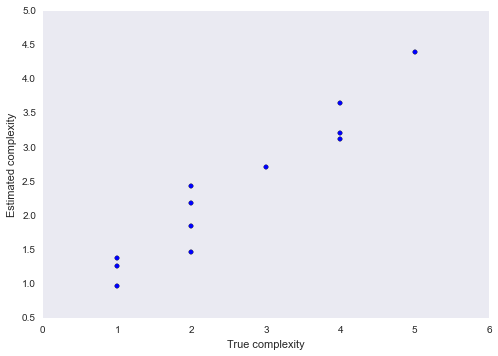

In [184]:
plt.scatter(Y_test,y_predrbf)
plt.xlabel("True complexity")
plt.ylabel("Estimated complexity")
plt.grid(b=False)

In [164]:
ALLdata = df.loc[:, ["logNdscr","logImg","Nstp","Nlnk", "Nxtra", "Nvid","dscrPerStp", "dscrPerImg", "scripts"]]
df.loc[:, "complexEstimate"] = rbfSVR.predict(scale(ALLdata))

In [165]:
df.describe()

,Nimg,Nlnk,Nstp,Nvid,Nxtra,scripts,Ndscr,daysold,dscrPerImg,dscrPerStp,logNdscr,logImg,complex,complexEstimate
count,34406.000000,34406.000000,34406.000000,34406.000000,34406.000000,34406.000000,34406.000000,34406.000000,34406.000000,34406.000000,34406.000000,34406.000000,82.000000,34406.000000
mean,18.544789,1.183718,6.673284,0.125443,0.403098,0.374121,4810.203453,1088.720427,325.632479,728.295599,8.021400,2.615899,3.048780,2.670896
std,19.228082,3.934014,4.370750,0.536438,1.644449,5.960945,5543.738015,896.114678,334.958849,614.082739,0.989209,0.734312,1.350834,0.973135
min,4.000000,0.000000,2.000000,0.000000,0.000000,0.000000,41.000000,10.000000,1.452381,2.277778,3.713572,1.386294,1.000000,0.867731
25%,8.000000,0.000000,4.000000,0.000000,0.000000,0.000000,1628.000000,310.000000,127.125000,314.500000,7.395108,2.079442,2.000000,1.829036
50%,13.000000,0.000000,6.000000,0.000000,0.000000,0.000000,3159.000000,831.000000,225.843826,564.232143,8.058011,2.564949,3.000000,2.764326
75%,22.000000,0.000000,8.000000,0.000000,0.000000,0.000000,5966.750000,1736.000000,401.226010,948.718750,8.693958,3.091042,4.000000,3.479119
max,298.000000,132.000000,123.000000,17.000000,157.000000,470.000000,150632.000000,3706.000000,4377.500000,5973.222222,11.922595,5.697093,5.000000,4.816555


In [166]:
f = open('rbfmodel.pickle','wb')
s = pkl.dump(rbfmodel,f)
f.close()
#clf2 = pickle.load(s)
# predict on ["logNdscr","logImg","Nstp","Nlnk", "Nvid","dscrPerStp", "scripts", "dscrPerImg"]

In [167]:
df.to_pickle('techno_df-with_estimates.pickle')

In [ ]:
dataDF.to_pickle('techno_data_with_estimates.pickle')

In [170]:
df.columns

Index([      u'projectID',            u'Nimg',            u'Nlnk',
                  u'Nstp',            u'Nvid',           u'Nxtra',
                 u'award',         u'scripts',        u'keywords',
                 u'title',        u'fulltext',           u'Ndscr',
               u'daysold',            u'tags',        u'category',
               u'channel',             u'url',      u'dscrPerImg',
            u'dscrPerStp',        u'logNdscr',          u'logImg',
               u'complex', u'complexEstimate'],
      dtype='object')

# Send features to MySQL

In [9]:
"/id/Hexapod4-Spider-RobotInstruction-Manual/" in dataDF.url.values

True

In [173]:
con = mdb.connect(user="root", host="localhost", db="instructables",  charset='utf8', unix_socket='/tmp/mysql.sock', port='3307')

In [174]:
#need to make sure these columns are there for modeling
#["logNdscr","logImg","Nstp","Nlnk", "Nxtra", "Nvid","dscrPerStp", "dscrPerImg", "scripts"]
testDB = df.loc[:, ["url", "title", "complexEstimate", "logNdscr", "logImg", "Nstp", "Nlnk", "Nxtra", "Nvid", "dscrPerStp", "dscrPerImg", "script", "channel", "tags", "keywords"]]
testDB.shape

(34406, 15)

In [175]:
testDB.to_sql(con=con, name='technoFeatures', if_exists='replace', flavor='mysql');
con.close()

/Users/Michel_home/anaconda/lib/python2.7/site-packages/pymysql/cursors.py:134: Warning: Data truncated for column 'title' at row 34
  result = self._query(query)
/Users/Michel_home/anaconda/lib/python2.7/site-packages/pymysql/cursors.py:134: Warning: Data truncated for column 'title' at row 49
  result = self._query(query)
/Users/Michel_home/anaconda/lib/python2.7/site-packages/pymysql/cursors.py:134: Warning: Data truncated for column 'title' at row 58
  result = self._query(query)
/Users/Michel_home/anaconda/lib/python2.7/site-packages/pymysql/cursors.py:134: Warning: Data truncated for column 'title' at row 72
  result = self._query(query)
/Users/Michel_home/anaconda/lib/python2.7/site-packages/pymysql/cursors.py:134: Warning: Data truncated for column 'title' at row 75
  result = self._query(query)
/Users/Michel_home/anaconda/lib/python2.7/site-packages/pymysql/cursors.py:134: Warning: Data truncated for column 'title' at row 90
  result = self._query(query)
/Users/Michel_home/ana

# READ DATA FROM PICKLED FILE

In [14]:
dataDF = pd.read_pickle("../Data/techno_data_with_estimates.pickle")
print dataDF.columns
dataDF.shape

Index([      u'projectID',            u'Nimg',            u'Nlnk',
                  u'Nstp',            u'Nvid',           u'Nxtra',
                 u'award',         u'scripts',        u'keywords',
                 u'title',        u'fulltext',           u'Ndscr',
               u'daysold',            u'tags',        u'category',
               u'channel',             u'url',      u'dscrPerImg',
            u'dscrPerStp',        u'logNdscr',          u'logImg',
               u'complex', u'complexEstimate'],
      dtype='object')


(34406, 23)

In [189]:
textList = [tex for tex in df.fulltext.values]
len(textList)

34406

In [ ]:
#################### TOKENIZATION ##################

In [70]:
import nltk.corpus
from nltk.corpus import stopwords
nltk.tag._POS_TAGGER


'taggers/maxent_treebank_pos_tagger/english.pickle'

In [192]:
mystopwords =  stopwords.words("english")
print len(mystopwords)
extrawords = ["make","need","using","get", "see","x", "m", "v","want", "d", "www", "org"]
for xtra in extrawords:
    mystopwords.append(xtra)
len(mystopwords)

127


139

In [103]:
corpa = ' '.join(textList[:50])
tokens = nltk.word_tokenize(corpa.lower())
pos = nltk.pos_tag(tokens)

In [104]:
#verbs = [v[0] for v in pos if v[1] in ['VB','VBN','VBG','VBP'] ]
#nouns = [v[0] for v in pos if v[1] in ['NN', 'NNP', 'NNPS', 'NNS'] ]
corpus = [v[0] for v in pos if (v[1] in ['NN', 'NNP', 'NNPS', 'NNS','VB','VBN','VBG','VBP']) and (v[0] not in mystopwords)]
len(corpus)

26976

In [63]:
tags = [v for w,v in pos]
unique = []
for tag in tags:
    if tag not in unique:
        unique.append(tag)
print unique

['JJS', 'IN', 'PRP', 'VBP', 'RB', 'VB', 'NN', 'DT', 'VBN', 'WDT', 'MD', 'WRB', 'CC', 'JJ', 'VBZ', 'VBG', 'TO', 'NNS', 'NNP', 'RP', 'PRP$', 'VBD', 'JJR', 'NNPS', 'RBR', 'CD', 'EX', 'RBS', 'WP', 'WP$', 'PDT', 'FW']


In [64]:
for v in pos:
    if v[1] == 'FW':
        print v 

(u'De', 'FW')
(u'de', 'FW')


# stem and lemma

In [108]:
from nltk.stem.snowball import SnowballStemmer

In [122]:
stemmer = SnowballStemmer("english")

In [123]:
test = [stemmer.stem(word) for word in textList[5].split()]
print textList[5].split()[:15]
test[:15]

[u'In', u'this', u'project', u'we', u'will', u'be', u'making', u'a', u'wireless', u'side', u'lamp', u'that', u'can', u'be', u'controlled']


[u'in',
 u'this',
 u'project',
 u'we',
 u'will',
 u'be',
 u'make',
 u'a',
 u'wireless',
 u'side',
 u'lamp',
 u'that',
 u'can',
 u'be',
 u'control']

In [274]:
# for every text, process them with stop words
stemmer = SnowballStemmer("english")
newdocumentO =[] 
for document in textList[34405:34406]:
    tokens = nltk.word_tokenize(document.lower())
    pos = nltk.pos_tag(tokens)
    relevant = [v[0] for v in pos if (v[1] in ['NN', 'NNP', 'NNPS', 'NNS','VB','VBN','VBG','VBP']) and (v[0] not in mystopwords)]
    stemmed = [stemmer.stem(word) for word in relevant]
    newdocumentO.append(' '.join(stemmed))

In [275]:
len(newdocumentO)#[7031][:100]
#textList[9999][:200]

1

In [267]:
newdocumentK[0][:250]

u'music store mp player pattern convert vibrat headphon coil vibrat turn creat vibrat field perman magnet insid coil interact caus movement creat sound wave vibrat air step process send output mp player laser pointer headphon pick signal depend resisto'

In [276]:
testL = testL2+newdocumentH+newdocumentI+newdocumentJ+newdocumentK+newdocumentL+newdocumentM+newdocumentN+newdocumentO
len(testL)#newdocumentC[999][:100]#textList[7031][:200]

34406

In [277]:
with open("corpus_stemmed.pickle", 'wb') as f:
    pkl.dump(testL, f)

In [266]:
# retrieve dumped parsed documents
with open("../Data/newdocumentABCDEFG.pickle", 'rb') as f:
    testL2 = pkl.load(f)
print len(testL2)
testL2[9999][:100]

15500


u'warm touch screen glove go buy glove acryl spandex note materi work check comment lick lick tip take'

# Stemmed TF-IDF MATRIX


In [278]:

tfidf_vectorizer = TfidfVectorizer(max_df = .95, min_df= 2)
tfidf_matrix_stem = tfidf_vectorizer.fit_transform(testL)
tfidf_matrix_stem.shape

(34406, 50024)

In [295]:
doc_distance = cosine_similarity(tfidf_matrix_stem[:7000], tfidf_matrix_stem)
s = doc_distance[2]
indices = sorted(range(len(s)), reverse = True, key=lambda k: s[k])
indices[:10]

[2, 28789, 23254, 24633, 29418, 31320, 34020, 927, 20613, 28606]

In [373]:
indexes = []
doc_distance = cosine_similarity(tfidf_matrix_stem[30000:], tfidf_matrix_stem)

for cos in doc_distance:
    indices = sorted(range(len(cos)), reverse = True, key=lambda k: cos[k])
    indexes.append(indices[:15])
    
with open("matchlist30000-34400.pickle", 'wb') as f:
    pkl.dump(indexes,f)    ##### THis gives the index of the closest 9 projects

In [374]:
bestmatch = bestmatch +indexes

In [378]:
with open("../Data/matchlist.pickle", 'rb') as f:
    bmatch = pkl.load(f)

In [395]:
bestmatch[2]

[2,
 28789,
 23254,
 24633,
 29418,
 31320,
 34020,
 927,
 20613,
 28606,
 2751,
 7734,
 27263,
 17248,
 26050]

In [297]:
sorted(s,reverse = True)

[1.0000000000000002,
 0.40286128134239357,
 0.40069547187196441,
 0.39615158301679276,
 0.3932603444891497,
 0.38876697680868938,
 0.38528204726151777,
 0.37510993218431643,
 0.3648278014208447,
 0.35879946405737911,
 0.35629211300378683,
 0.3550916279459661,
 0.3520134068413675,
 0.35026610042132972,
 0.34840518069409615,
 0.34784501365523762,
 0.34771193931796796,
 0.34735407851312206,
 0.34728018315436776,
 0.34646895502958724,
 0.34300919650830336,
 0.3413788847483078,
 0.34095793217027703,
 0.34040102881034617,
 0.3401135951118312,
 0.33862841995183501,
 0.33860460643074136,
 0.3385562059694906,
 0.33807694203922056,
 0.33781518364634772,
 0.33484384795325728,
 0.33012812234260841,
 0.32946027729261057,
 0.32737573591663643,
 0.32733818217110133,
 0.3251645356123064,
 0.32343848081992305,
 0.32326134989808719,
 0.32296278702297748,
 0.32272238666506053,
 0.32219663242110291,
 0.32211965789175062,
 0.32004313425597813,
 0.31995227321070507,
 0.31896312051558667,
 0.3179725799966982

In [354]:
tfidf_matrix_stem.shape

(34406, 50024)

In [396]:
df.iloc[2].url

u'/id/SENSOR-SET-TESTING-SKETCHES-for-aquaponic-Balcony-/'

In [394]:
#getSimProjects(2)
bestmatch[29838]

[29838,
 33122,
 18618,
 31972,
 14395,
 31084,
 30245,
 15190,
 927,
 14217,
 27284,
 26431,
 13001,
 28066,
 32428]

In [105]:
corpusFreq = nltk.FreqDist(corpus)
#verbcount = nltk.FreqDist(verbs)
#nounscount = nltk.FreqDist(nouns)

In [ ]:
corpusFreq.plot(40)
#verbcount.plot(30, cumulative = False)

In [ ]:
text = nltk.Text(tokens)
freq1 = nltk.FreqDist(ch.lower() for ch in text if ch.isalpha())
freq1.plot(70,cumulative = True)

In [ ]:
raw = " ".join(des2)
tokens = nltk.word_tokenize(raw)
lengths = [(len(fdr),fdr) for fdr in tokens ]
lengths.sort(reverse=True)
lengths

In [198]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [197]:
documents = textList[:]
len(documents)

34406

In [236]:
tfidf_vectorizer = TfidfVectorizer(max_df = .92, min_df= 7)
tfidf_matrix = tfidf_vectorizer.fit_transform(documents)
tfidf_matrix.shape
#min = 2 yields 74000 words
#min = 5 yields 37506 words
#min = 7 yields 30776 words
#min = 8 yields 28000 words

(34406, 30776)

In [237]:
tfidf_min7 = tfidf_matrix

In [279]:
with open("tfidf_matrix_allSTEMMED_min2_max95.pickle", 'wb') as f:
    pkl.dump(tfidf_matrix_stem,f)

In [337]:
cosARRAY = cosine_similarity(tfidf_matrix[7000:10000], tfidf_matrix)


In [338]:
len(cosARRAY)

3000

In [ ]:
with open("cos_sim_matrix_first4000.pickle", 'wb') as f:
    pkl.dump(cosARRAY,f)

In [308]:
# INDEX of the most similar projects
cosARRAY = cosine_similarity(tfidf_matrix[0:7], tfidf_matrix)
s = cosARRAY[0]
indices = sorted(range(len(s)), reverse = True, key=lambda k: s[k])
indices[:10]
# for min=2, max=95 --> [2, 927, 29817, 28789, 24633, 21254, 526, 34020, 30195, 31320]
# for min=2, max=95 --> [2, 28789, 927, 29817, 7734, 31320, 34020, 22613, 24633, 21254]
##for STEMMED WORDS --> [2, 28789, 23254, 24633, 29418, 31320, 34020, 927, 20613, 28606]

[0, 21797, 34031, 32408, 25770, 8982, 33944, 2554, 22042, 2121]

In [340]:
indexes = []
for cos in cosARRAY:
    indices = sorted(range(len(cos)), reverse = True, key=lambda k: cos[k])
    indexes.append(indices[:15])
    
with open("indexes4000-7000.pickle", 'wb') as f:
    pkl.dump(indexes,f)    ##### THis gives the index of the closest 9 projects

In [341]:
len(indexes)

3000

In [350]:
topmatch = indexesA+indexes


In [351]:
#indexesA = indexesA[:4000]
len(topmatch)

7000

# Validation of tf-idf


In [231]:
print cosARRAY[0][21]
print cosARRAY[0][31033]

1.0
0.512940677458


In [268]:
for t in dataDF.iloc[[7,4741, 1509, 3869, 6219, 3562]].fulltext:
#for t in dataDF.iloc[[7,4744, 1549, 3849, 6249, 3542]].fulltext:
    print t.count('led ')

2
21
6
16
2
5


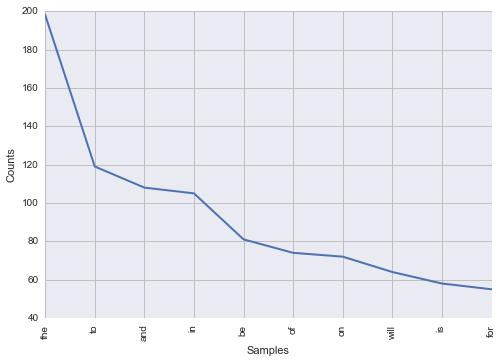

In [324]:
#nltk.FreqDist(nltk.word_tokenize(df.loc[2].fulltext)).plot(10)
TfidfVectorizer(max_df = .92, min_df= 7).fit(df.loc[2].fulltext)#print df.loc[927].tags
#print df.loc[29817].tags

In [ ]:
for document in df.iloc[indices[:7]].fulltext;
    tokens = nltk.word_tokenize(document.lower())
    pos = nltk.pos_tag(tokens)
    relevant = [v[0] for v in pos if (v[1] in ['NN', 'NNP', 'NNPS', 'NNS','VB','VBN','VBG','VBP']) and (v[0] not in mystopwords)]
    relevant.FreqDist